<a href="https://colab.research.google.com/github/paulandrea0/Qualifica-PCA/blob/main/CrossValidation_en_la_Copia_de_PCA_MLPercepton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
df_test_1 = pd.read_csv('/content/drive/MyDrive/Sismos/VT_Z_teste.csv')
df_train_1 = pd.read_csv('/content/drive/MyDrive/Sismos/VT_Z_train.csv')
df_test_2 = pd.read_csv('/content/drive/MyDrive/Sismos/LP_Z_teste.csv')
df_train_2 = pd.read_csv('/content/drive/MyDrive/Sismos/LP_Z_train.csv')
df_test_3 = pd.read_csv('/content/drive/MyDrive/Sismos/TOR_Z_teste.csv')
df_train_3 = pd.read_csv('/content/drive/MyDrive/Sismos/TOR_Z_train.csv')
sismos = pd.read_excel('/content/drive/MyDrive/Sismos/Distribución de datos sísmicos.xlsx')

In [4]:
sismos.fillna(0, inplace=True)
sismos = sismos.rename(columns={'VTz':'VT seism',
                                   'LPz':'LP seism', 'Tor z':'TOR seism'})

print(sismos.head)
sismos.dtypes

<bound method NDFrame.head of       VT seism     VTn     Vte  LP seism     LPn     LPe  TOR seism    Tor n  \
0         2157  2157.0  2157.0    3000.0  3000.0  3000.0     4672.0   4672.0   
1         2893  2893.0  2893.0    3000.0  3000.0  3000.0     3096.0   3096.0   
2         2207  2207.0  2207.0    3000.0  3000.0  3000.0     7956.0   7956.0   
3         1794  1794.0  1794.0    3000.0  3000.0  3000.0     6507.0   6507.0   
4         1135  1135.0  1135.0    3000.0  3000.0  3000.0    10262.0  10262.0   
...        ...     ...     ...       ...     ...     ...        ...      ...   
1731      2030     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1732      1480     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1733      1347     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1734      1838     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1735      1449     0.0     0.0       0.0     0.0     0.0        0.0      0.0   

        T

VT seism       int64
VTn          float64
Vte          float64
LP seism     float64
LPn          float64
LPe          float64
TOR seism    float64
Tor n        float64
Tor e        float64
dtype: object

In [5]:
import seaborn as sns

sis = (sismos['VT seism'], sismos['LP seism'], sismos['TOR seism'])
print(sis)

(0       2157
1       2893
2       2207
3       1794
4       1135
        ... 
1731    2030
1732    1480
1733    1347
1734    1838
1735    1449
Name: VT seism, Length: 1736, dtype: int64, 0       3000.0
1       3000.0
2       3000.0
3       3000.0
4       3000.0
         ...  
1731       0.0
1732       0.0
1733       0.0
1734       0.0
1735       0.0
Name: LP seism, Length: 1736, dtype: float64, 0        4672.0
1        3096.0
2        7956.0
3        6507.0
4       10262.0
         ...   
1731        0.0
1732        0.0
1733        0.0
1734        0.0
1735        0.0
Name: TOR seism, Length: 1736, dtype: float64)


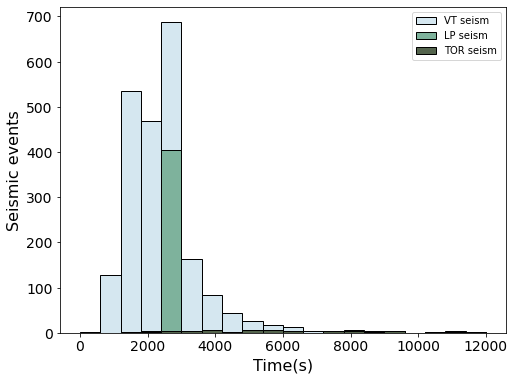

In [6]:
from seaborn.rcmod import set_palette
import seaborn as sns

plt.figure(figsize = (8, 6))
axes = plt.gca()
sns.histplot(sis, binrange=(1,12000), bins=20, multiple="stack", palette=sns.cubehelix_palette(3, start=1.6), kde=False)

plt.ylabel('Seismic events')
plt.xlabel('Time(s)')
# plt.title('Distribution of seismic event duration')

axes.title.set_size(20)
axes.xaxis.label.set_size(16)
axes.yaxis.label.set_size(16)
axes.tick_params(axis='both', labelsize=14)
plt.show()
axes.figure.savefig('Histograma.tiff', dpi=400, format='tiff')

(1480, 13348)
(256, 10993)
(362, 3000)
(40, 3000)
(61, 21494)
(6, 27408)


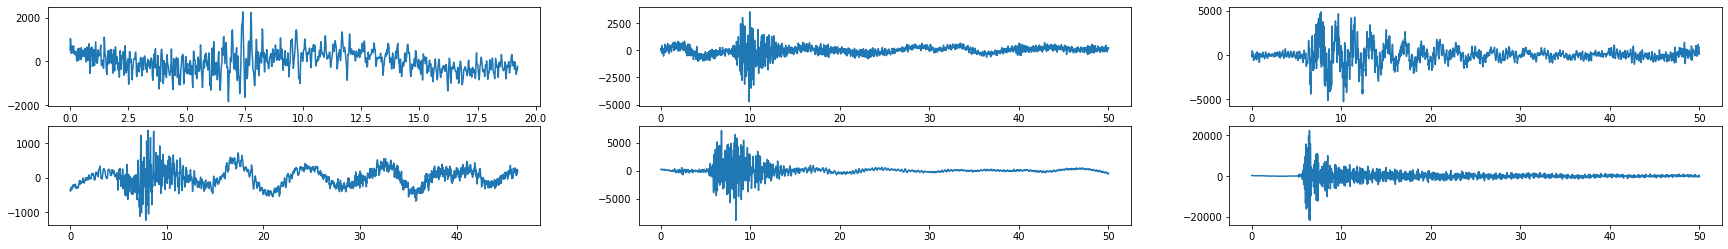

In [7]:
# Creando función para retirar el offset de los datos en DataFrame
def mean_norma(df_input):
  return df_input.apply(lambda x: (x-x.mean()), axis=1)

df_mean_test_1 = mean_norma(df_test_1) # Señales VT
df_mean_train_1 = mean_norma(df_train_1)
df_mean_test_2 = mean_norma(df_test_2) # Señales LP
df_mean_train_2 = mean_norma(df_train_2)
df_mean_test_3 = mean_norma(df_test_3) # Señales Tor
df_mean_train_3 = mean_norma(df_train_3)

print(df_mean_train_1.shape)
print(df_mean_test_1.shape)
print(df_mean_train_2.shape)
print(df_mean_test_2.shape)
print(df_mean_train_3.shape)
print(df_mean_test_3.shape)

# Convirtiendo el dataframe en array
d_train_1 = df_mean_train_1.values
d_train_1 = d_train_1[:, 0:3000]
d_test_1 = df_mean_test_1.values
d_test_1 = d_test_1[:, 0:3000]

d_train_2 = df_mean_train_2.values
d_train_2 = d_train_2[:, 0:3000]
d_test_2 = df_mean_test_2.values
d_test_2 = d_test_2[:, 0:6000]

d_train_3 = df_mean_train_3.values
d_train_3 = d_train_3[:, 0:3000]
d_test_3 = df_mean_test_3.values
d_test_3 = d_test_3[:, 0:3000]

# Dibujando la señal orioginal
n = 3000
fs = 50 # frecuencia de muestreo
t = np.linspace(0,fs,n)
plt.figure(1, figsize=(30, 4))
plt.subplot(231)
plt.plot(t, d_train_1[60])
plt.subplot(232)
plt.plot(t, d_train_2[18])
plt.subplot(233)
plt.plot(t, d_train_3[38])
plt.subplot(234)
plt.plot(t, d_test_1[44])
plt.subplot(235)
plt.plot(t, d_test_2[34])
plt.subplot(236)
plt.plot(t, d_test_3[4])

(1480, 3000)
(256, 3000)
(362, 3000)
(40, 3000)
(61, 3000)
(6, 3000)


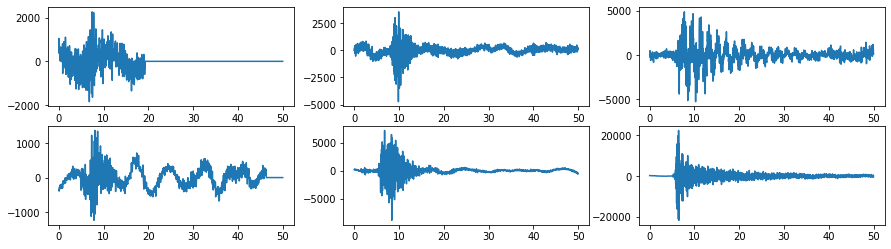

In [8]:
# Quitando los valores NaN de los array numpy

# Señales VT
d_train_1[np.isnan(d_train_1)] = 0.0
d_test_1[np.isnan(d_test_1)] = 0.0
print(d_train_1.shape)
print(d_test_1.shape)

# Señales LP
d_train_2[np.isnan(d_train_2)] = 0.0
d_test_2[np.isnan(d_test_2)] = 0.0
print(d_train_2.shape)
print(d_test_2.shape)

# Señales Tor`
d_train_3[np.isnan(d_train_3)] = 0.0
d_test_3[np.isnan(d_test_3)] = 0.0
print(d_train_3.shape)
print(d_test_3.shape)

# Graficando
plt.figure(2, figsize=(15, 4))
plt.subplot(231)
plt.plot(t, d_train_1[60])
plt.subplot(232)
plt.plot(t, d_train_2[18])
plt.subplot(233)
plt.plot(t, d_train_3[38])
plt.subplot(234)
plt.plot(t, d_test_1[44])
plt.subplot(235)
plt.plot(t, d_test_2[34])
plt.subplot(236)
plt.plot(t, d_test_3[4])

# **P C A**

In [9]:
from sklearn.decomposition import PCA
# concatentando los datos de entrenamiento y teste para calcular los PCA
VT = np.concatenate([d_train_1,d_test_1], axis=0)
LP = np.concatenate([d_train_2,d_test_2], axis=0)
Tor = np.concatenate([d_train_3,d_test_3], axis=0)

pca = PCA(n_components=0.95)
VT_pca = pca.fit_transform(VT)
LP_pca = pca.fit_transform(LP)
Tor_pca = pca.fit_transform(Tor)

print(d_train_1.shape, d_test_1.shape, VT.shape, VT_pca.shape)
print(d_train_2.shape, d_test_2.shape, LP.shape, LP_pca.shape)
print(d_train_3.shape, d_test_3.shape, Tor.shape, Tor_pca.shape)

(1480, 3000) (256, 3000) (1736, 3000) (1736, 6)
(362, 3000) (40, 3000) (402, 3000) (402, 84)
(61, 3000) (6, 3000) (67, 3000) (67, 31)


In [10]:
sismos = np.concatenate([VT, LP, Tor], axis=0)
pca = PCA(n_components=0.95)
sismos_pca = pca.fit_transform(sismos)
print(sismos.shape, sismos_pca.shape)

(2205, 3000) (2205, 7)


Calculando 67 PCA para todos los datos de entrenamiento y prueba (67 que es la
cantidad de ejemplos que se tienen para una de las clases).


In [11]:
pca = PCA(n_components=50)
vt_pc = pca.fit_transform(VT)
lp_pc = pca.fit_transform(LP)
tor_pc = pca.fit_transform(Tor)
print(vt_pc.shape, lp_pc.shape, tor_pc.shape)

(1736, 50) (402, 50) (67, 50)


Volvemos a separa el set de datos en set de entrenamiento y set de prueba para su
respectiva normalización.

In [12]:
d_train_1, d_test_1 = vt_pc[0:1480 :], vt_pc[1480:1737, :]
d_train_2, d_test_2 = lp_pc[0:362 :], lp_pc[361:403, :]
d_train_3, d_test_3 = tor_pc[0:61 :], tor_pc[61:68, :]

print(d_train_1.shape, d_test_1.shape)
print(d_train_2.shape, d_test_2.shape)
print(d_train_3.shape, d_test_3.shape)

(1480, 50) (256, 50)
(362, 50) (41, 50)
(61, 50) (6, 50)


# **Normalización**

Mínimo y máximo originales: -2600460.4, 18090713.4
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: -304042.3, 1018660.3
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: -85848.7, 232894.7
Mínimo y máximo normalizado: 0.0, 1.0


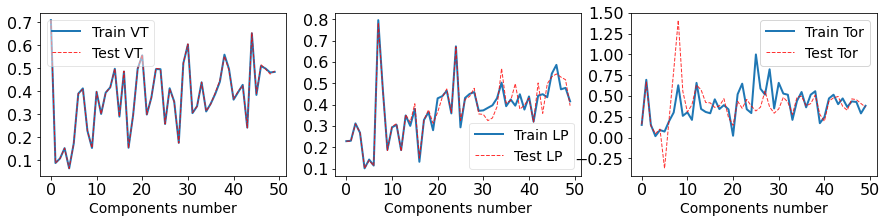

In [13]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# Señales VT
D_train_s1 = min_max_scaler.fit_transform(d_train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(d_train_1), np.max(d_train_1)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s1), np.max(D_train_s1)))
D_test_s1 = min_max_scaler.transform(d_test_1)

# Señales LP
D_train_s2 = min_max_scaler.fit_transform(d_train_2)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(d_train_2), np.max(d_train_2)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s2), np.max(D_train_s2)))
D_test_s2 = min_max_scaler.transform(d_test_2)

# Señales Tor
D_train_s3 = min_max_scaler.fit_transform(d_train_3)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(d_train_3), np.max(d_train_3)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s3), np.max(D_train_s3)))
D_test_s3 = min_max_scaler.transform(d_test_3) 

# Graficando
plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(D_train_s1[60], lw=2, label="Train VT")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.subplot(132)
plt.plot(D_train_s2[18], lw=2, label="Train LP")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.subplot(133) 
plt.plot(D_train_s3[38], lw=2, label="Train Tor")
plt.legend(fontsize='14')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)



plt.subplot(131)
plt.plot(D_test_s1[44], 'r--', alpha=0.8, lw=1, label="Test VT")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xlabel('Components number', fontsize='14')
plt.subplot(132)
plt.plot(D_test_s2[34], 'r--', alpha=0.8, lw=1, label="Test LP")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xlabel('Components number', fontsize='14')
plt.subplot(133)
plt.plot(D_test_s3[4], 'r--', alpha=0.8, lw=1, label="Test Tor")
plt.legend(fontsize='14')
plt.xlabel('Components number', fontsize='14')

plt.savefig('caracter_PCA.tiff', dpi=400, format='tiff')

# **Clasificación con MLPerceptron**

Preparando los datos para ser presentados en el clasificador

In [14]:
# a continuación son adicionadas tres columnas que me permitirán ser usadas
D_train_s1 = np.insert(D_train_s1, [0], (1,0,0), axis=1)
D_test_s1 = np.insert(D_test_s1, [0], (1,0,0), axis=1)
D_train_s2 = np.insert(D_train_s2, [0], (0,1,0), axis=1)
D_test_s2 = np.insert(D_test_s2, [0], (0,1,0), axis=1)
D_train_s3 = np.insert(D_train_s3, [0], (0,0,1), axis=1)
D_test_s3 = np.insert(D_test_s3, [0], (0,0,1), axis=1)

print(D_train_s1[1,0:5], D_test_s1[1,0:5])
print(D_train_s2[1,0:5], D_test_s2[1,0:5])
print(D_train_s3[1,0:5], D_test_s3[1,0:5])
print(D_train_s1[1,0:5], D_test_s1[1,0:5])
print(D_train_s2[1,0:5], D_test_s2[1,0:5])
print(D_train_s3[1,0:5], D_test_s3[1,0:5])

# Creo mi set de entrenamiento con sismos y sus etiquetas correspondientes y
set_train = np.concatenate([D_train_s1,D_train_s2, D_train_s3], axis=0)
set_test = np.concatenate([D_test_s1,D_test_s2, D_test_s3], axis=0)
y_vector = np.concatenate([set_train, set_test])
y_vector = y_vector[:,0:3]

# le doy una mezcla a los datos para que entren en desorden en la red neuron
np.random.shuffle(set_train)
np.random.shuffle(set_test)

print(set_train.shape, set_test.shape)

[1.         0.         0.         0.70926998 0.08769767] [1.         0.         0.         0.70930351 0.08773183]
[0.         1.         0.         0.22917182 0.23089353] [0.         1.         0.         0.22849763 0.22968349]
[0.         0.         1.         0.14981517 0.66598995] [0.         0.         1.         0.1602789  0.66023212]
[1.         0.         0.         0.70926998 0.08769767] [1.         0.         0.         0.70930351 0.08773183]
[0.         1.         0.         0.22917182 0.23089353] [0.         1.         0.         0.22849763 0.22968349]
[0.         0.         1.         0.14981517 0.66598995] [0.         0.         1.         0.1602789  0.66023212]
(1903, 53) (303, 53)


In [15]:
print(set_train.shape, set_test.shape)
y_train, X_train = set_train[:,0:3], np.delete(set_train, range(0, 3), axis=1)
y_test, X_test = set_test[:,0:3], np.delete(set_test, range(0, 3), axis=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(y_train[1,0:5], X_train[1,0:5])
print(y_test[1,0:5], X_test[1,0:5])

X = np.concatenate([X_train,X_test], axis=0) 
y = np.concatenate([y_train,y_test], axis=0) 
print(X.shape, y.shape)

(1903, 53) (303, 53)
(1903, 50) (1903, 3) (303, 50) (303, 3)
[0. 1. 0.] [0.22734202 0.22930949 0.31266899 0.27243889 0.1091428 ]
[1. 0. 0.] [0.70919956 0.08768134 0.10769582 0.15224022 0.06441359]
(2206, 50) (2206, 3)


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Sequential
from keras.regularizers import l2 # cuando hay sobreajuste la regularización
# a decartar valores altos en la función de costo. Se puede colocar en cualq
from keras.layers import Dropout #apagar aleatoriamente algunas neuronas,
# ayudando a eliminar el sobreajuste
from keras.callbacks import EarlyStopping

Entrenamos un MLP para clasificar tres clases de sismos

In [17]:
#np.random.seed(23)

dim_entrada = X_train.shape[1]
entrada = Input(shape=(dim_entrada,))

print(X_train.shape[1])
x = Dense(500, activation='relu', kernel_regularizer=l2(0.005))(entrada)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.25)(x)
saida = Dense(3, activation='softmax')(x)
clasificador = Model(inputs=entrada, outputs=saida)
clasificador.summary()

50
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 500)               25500     
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 75,903
Trainable params: 75,903
Non-trainabl

In [18]:
y_label = []
for i in range(len(y)):
  if y[i,0] > 0:
    y_label.append(0)
  if y[i,1] > 0:
    y_label.append(1)
  if y[i,2] > 0:
    y_label.append(2)
y_label = np.array(y_label)
print(y_label.shape)

(2206,)


# Implementando Validación Cruzada Estratificada y Clasificación

In [19]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

Definimos la configuracipon de Validacipon Cruzada estratificada y luego el modelo de clasificación:

In [20]:
cv = StratifiedShuffleSplit(n_splits=6, random_state=True)

clasificador = Model(inputs=entrada, outputs=saida)

# Aplicando CrossValidation en los datos PCA

StratifiedShuffleSplit(n_splits=6, random_state=True, test_size=None,
            train_size=None)
TRAIN: [ 295 1625  409 ...  233   22  548] TEST: [ 778 1088 1940  251 1831  405 1212 1448  319 1679  215  843 2152  419
 1723  192 1418  765 1367 1744  736 1815 1750 1338 1455 1160  718 2142
  404  355 1293 1441 2038 1487 1623 1129 1203 1437  562  540 1167 1971
  626 1819 1621  307  826 1096  269 2068  123 1710 2108   35 1552 1767
 1244  357 1358 1412  823  178  926  734 1410  652  630  407  136 1693
  969 1803 1083  189 1359  206 1093 1121 1334 2065 2045  756 1187 1574
  802  296  809 2051 1649  356 1684 1295  181 2156 2133 1184 1606 1698
 1901  360  560  163 1373 1501  344 1423 1345 2199  903 1943 2111 1250
  660 1918  868 1569 1855    1 1006  939  675 1161 1149  464 2132 1913
 1419  526 1789 1173  605 1381 1705 2011  819  607 1972  299 1732 1435
 1536 1850  943 1754 1859 1996 2200  731 1923  971  519  817 1317 1563
  917  332 2057 1775 2008  967  165 2028 1601  186  401  689 1070 1205


TRAIN: [1276 1741  540 ... 1075 1033  911] TEST: [1065  575  509  999  757  806 1804  881 2169 1147   47  954 1030 1293
  266  409 1123 2095 1343 1978 1370  946  854 1760 1999  110  775  270
  652 2036  291  410 1829 1569 1420 1167   42  496  884 1411 1726 1105
 2159  632  133 1401  100  976 1287 1512 1037   52  610  524 1431  113
 1458 1050   76 1752  469  548  841  310  289 1670 1436 1501  886  809
 1465 1482 1473  245 2032 1794  766 2184 1101 1934  430 1960 1580 2024
  856 1223 1859  782 1387  813 1412 1059 2028  576 1676 2134 1769 1779
 1909  345 2127  471 2003  808  106  152  286  367   98  324  336 2132
  661 1448  422  656 1169 1067 1534  848 1766  914  164  487  600  150
  714 1349 1456 1452 1497  252 1888 1740 1365 1316  514 1495 1333   67
 1172  753   19 1164 1944  629  126 1721  979  248 1244 1367 1814 2143
  168 1785 2187 1639 1880 1967  858  466 1240 1250  670 1644 1805 1263
 1882  517  285 1793  241  657 1659 1589 1974 2124 1364 1449  282  828
 1417 1157  338 1261 1479 14

TRAIN: [  84   39  276 ...  445 1381 1398] TEST: [1387 1075  577 1863 2178  299 1787  496  359 1020  371 2096  458 1916
  789  954  787 1492  338  353  343  149  203 2019  871 2157 1464  814
  959  399 2025  131 1476 1407 1735  270 2192  958 1302 1213 1649  455
 1231 1040 2000  504 2093 1903   93 2021  367   34 1671 2188 1145  341
 2162 1981 2193  211  503 1397  762  188 1488 1249  202 1543 1178 1730
  317 1500 1083 1144 1941  602  492  832 1319 1775 1498 1345  258 1879
  525 1170 1705 1085 1121 2012 1798   97 1137 1760  927 2198  108 1376
  980 1614 1089  648 2181 1882 1354 2052 2010 2159  354  366 2074  948
 1665  700  326  210 2055  265 1568  419  800  868 1299 1127 2082  794
 1612  368  991  379 1734  745  748 1728 1859  755 1828 1600 1792 1208
 1252  801 1569  431 2144 1934 1674  213  950  962 1560  117 2020  912
 1343  710 1800 1016 1549  692 1542 2092 1214 2073  825 1585 1117  252
 1677 1468  759   71  413  540 1821  670 1593  195 2116 1627 1211 1280
  280 2075  910  727  308  9

TRAIN: [1452  199 1444 ... 1570  571 1793] TEST: [2033  984  508  568  195   43  802  485 1154  564 2085   68  269 1662
  264 1721  789  785  655  625  918 1178  738  450  391   23   90 1614
 1083 1690  627 1839 1660 1851 1102 1064  204  794 1827 1222  772 2178
 2134 1428 1625 1975 1628  935 1961  341 2124 1792 2001 2069  973 1115
  549 1552  384 1679  473  793 2117 1889 2147 2008  758  371  454 2128
 1500  848 1801 1527  365 1547  197 1404 1011 2129  783 1930 1476   45
  478   81  995  532  801  724 2139 1461  658  364  157 1180 1019 1713
 1798  132 1658 1122 1409  208  678 1533  289  133  320  346 1038  835
 1125  523  931  129  358  753  597 1621 1365 1766 2046 1171  103 2174
 1511  806 1735  367 1888  891 1799 1297 1682  874 1736 1895 1090  878
 1281 1212 1134 1837 1139 1850 1707  751   41 2133  177 1124 1762  198
 1197 1334 1194  866 1241  175 1179  723  969  552 1278 1783 2154 1285
 1911  142 2094 2150 1033 1853 1097  798  702 2070 2032  750 1687 1034
 1403 1264 2127 1405    3  4

TRAIN: [2192  520 1149 ... 1274 1723 1757] TEST: [  17 1461  319 1652  575 1087 1004 1229  647   25  911 1211 1783 1184
  164  773  929  640 1684 1843  770 1040 1863   38 1097  596 1011 1318
  140  485 2008  779 1725 1779  210  118  746  141 2030 1113 2003  148
 1059 1135  788 1500 1587 1311  895 1233 1246 2036 1077  237  823 1375
  661  723  562 1002  965  580  545 1226 1611  376 1376 1625 1934  486
 1486 1315 1192  355 1785 1164 1276  793  132  212  326 2060 2020  276
 1392  200 2058 1439  496 1262 1513  172  784 1847   11  196  957  794
  620  915 1936  716  450  384  145 1224  632 1718 1931 1012 1641 1046
  670 1175 1693 1552 1285  835 1207 2075  283 1908  514  465 1289 1768
 1038 1028 1520 1575 1365 1998 1350 2177  843 1927  401  506  554 1747
 1291 1035 2066 1055 1981   48 1771  563 2107  399 1136  667 1159 1653
 1001  232  468  876    3 1800  273  191 1434 1324  969  227 1760  375
    4 1930 1156  573 1467 1471 1056 2024 1232  836  289  437 1162 1888
  311 1172  385  297  539  1

TRAIN: [ 416  360  321 ...  566 1117  533] TEST: [ 662  850  453 2053  383  983  170 1082 1090  615 1243  160 1559 1291
 2006 1588  266 1257 2136  428 1961  599  427 1097  224 1309  937  747
  339    6  527  488 1660 1633 1879  541  858 2193  721 1498 1464 1105
  830  975  554 2184  522 1128 1386   51   32 1894   18  661  625 1232
 1930 1865  513  331  108 1552 1201 1544 1012 2105 1405   58  571 1706
  745 1541 1668  776 1038 1762  605 1749 1226 1310  276  701  154 2064
 1788  136  763 1674 1848 2075 1748  128  297 1192  365 1585 1312  631
    3  546  143  932 2010 1619  112  723  184  407  452 1917   49  363
 2091 1556 2072 2043 1391  454  162  928   84 1593  316  124 1729 2088
 1923 2190  471 1598 1323 1002 1522  219 1831  140  769 1581  946 2001
 1859 1565 1671 1319  967  996  130  885  957 1134 1856  441 1245 1804
 1618  586 2103  956 1146 2018 1198  898  504 2154 1603 1493  101 1142
  940   33 1920 1767 1360  324 1252 1068  433  734 1049 1069 1418 1527
  618 1830 1212 1878 1777 10

train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]


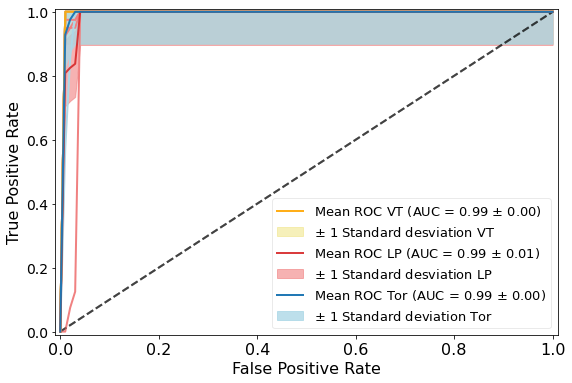

<Figure size 432x432 with 0 Axes>

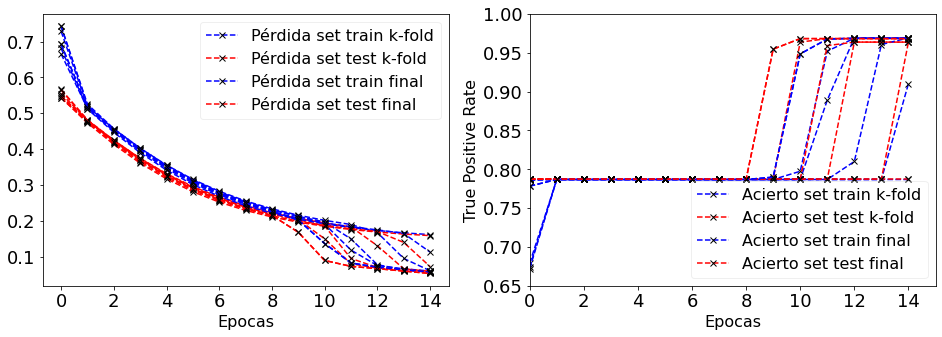

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#cv.get_n_splits(X, y_label)

print(cv)
StratifiedShuffleSplit(n_splits=6, random_state=True)

fig, ax = plt.subplots(1, figsize = (9, 6))
tprs_mean_0 = []
tprs_mean_1 = []
tprs_mean_2 = []
aucs_0 = []
aucs_1 = []
aucs_2 = []
fold = 1

for train_index, test_index in cv.split(X, y_label):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  

  dim_entrada = X.shape[1]      
  entrada = Input(shape=(dim_entrada,))
  x = Dense(500, activation='relu', kernel_regularizer=l2(0.005))(entrada)
  x = Dropout(0.25)(x)
  x = Dense(100, activation='relu')(x)
  x = Dropout(0.25)(x)
  saida = Dense(3, activation='softmax')(x)

  
  clasificador = Model(inputs=entrada, outputs=saida)
  clasificador.compile(optimizer='adam', loss='mae', metrics=['categorical_accuracy'])
  historia = clasificador.fit(X_train, y_train,    
                           epochs=15,
                           batch_size=250,
                           validation_data=(X_test, y_test),    
                           shuffle=True)
  
  print("ENTRENAMIENTO EN EL FOLD %0.2f" %(fold))
  y_pred = clasificador.predict(X_test)
  
  tprs = []
  Corte = []
  
  base_fpr = np.linspace(0, 1, 101)
  mean_fpr = np.linspace(0, 1, 100)


  #Curva ROC para la clase VT

  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 0],  y_pred[:,0])
    auc1 = roc_auc_score(y_test[:, 0], y_pred[:, 0])   # Es auc1, o deberia ser auc0????????  no importa porque luego forma un vector para cada tipo de sismo

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_0.append(auc1)

  Corte.append(th[np.argmax(tpr - fpr)])
  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k",  
          alpha=0.2)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="orange",
      lw=2,
      alpha=0.9,
  )
  tprs_mean_0.append(mean_tpr)

  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate', fontsize=16)
  plt.xlabel('False Positive Rate', fontsize=16)


  #Curva ROC para la clase LP

  tprs = []
  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 1],  y_pred[:, 1])
    auc1 = roc_auc_score(y_test[:, 1], y_pred[:, 1])

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_1.append(auc1)

  Corte.append(th[np.argmax(tpr - fpr)])

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="lightcoral",
      lw=2,
      alpha=0.99, # alpha es transparencia 
  )
  tprs_mean_1.append(mean_tpr)

  #Curva ROC para la clase Tor
  
  tprs = []
  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 2],  y_pred[:, 2])
    auc1 = roc_auc_score(y_test[:, 2], y_pred[:, 2])    # Es auc1, o deberia ser auc0????????  no importa porque luego forma un vector para cada tipo de sismo

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_2.append(auc1)

  Corte.append(th[np.argmax(tpr - fpr)])

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="lightblue",
      lw=2,
  )
 
  tprs_mean_2.append(mean_tpr)
  ax.legend(loc="lower right",fontsize = 8)
  plt.xticks(fontsize=16), plt.yticks(fontsize=14)


  import matplotlib.pyplot as plt
  plt.figure(5, figsize=(16,5))
  plt.subplot(1,2,1)
  plt.plot(historia.history["loss"], 'xb--',mec='k', lw=1.5)   #label="Pérdida train (Fold %0.2f)" %(fold)
  plt.plot(historia.history["val_loss"], 'xr--',mec='k', lw=1.5)
  plt.subplot(1,2,2)
  plt.plot(historia.history["categorical_accuracy"], 'xb--',mec='k', lw=1.5)
  plt.plot(historia.history["val_categorical_accuracy"], 'xr--',mec='k', lw=1.5)
  
  fold = fold + 1  

for train, test in cv.split(X, y_label):
  print('train -  {}   |   test -  {}'.format(
      np.bincount(y_label[train]), np.bincount(y_label[test])))

plt.figure(3, figsize=(6,6))
tpr_0_final = np.mean(tprs_mean_0, axis=0)
std_tpr_0 = np.std(tpr_0_final, axis=0)
tprs_upper_0 = np.minimum(tpr_0_final + std_tpr_0, 1)
tprs_lower_0 = np.maximum(tpr_0_final - std_tpr_0, 0)

tpr_0_final[-1] = 1.0
mean_auc_0 = auc(mean_fpr, tpr_0_final)
std_auc_0 = np.std(aucs_0)
ax.plot(
    mean_fpr,
    tpr_0_final,
    color="orange",
    label=r"Mean ROC VT (AUC = %0.2f $\pm$ %0.2f)" %(mean_auc_0, std_auc_0),
    lw=2,
    alpha=0.9,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_0,
    tprs_upper_0,
    color="khaki",
    alpha=0.6,
    label="$\pm$ 1 Standard desviation VT",
)

tpr_1_final = np.mean(tprs_mean_1, axis=0)
std_tpr_1 = np.std(tpr_1_final, axis=0)
tprs_upper_1 = np.minimum(tpr_1_final + std_tpr_1, 1)
tprs_lower_1 = np.maximum(tpr_1_final - std_tpr_1, 0)

tpr_1_final[-1] = 1.0
mean_auc_1 = auc(mean_fpr, tpr_0_final)
std_auc_1 = np.std(aucs_1)
ax.plot(
    mean_fpr,
    tpr_1_final,
    color="tab:red",
    label=r"Mean ROC LP (AUC = %0.2f $\pm$ %0.2f)" %(mean_auc_1, std_auc_1),
    lw=2,
    alpha=0.9,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_1,
    tprs_upper_1,
    color="lightcoral",
    alpha=0.6,
    label="$\pm$ 1 Standard desviation LP",
)

tpr_2_final = np.mean(tprs_mean_2, axis=0)
std_tpr_2 = np.std(tpr_2_final, axis=0)
tprs_upper_2 = np.minimum(tpr_2_final + std_tpr_2, 1)
tprs_lower_2 = np.maximum(tpr_2_final - std_tpr_2, 0)

tpr_2_final[-1] = 1.0
mean_auc_2 = auc(mean_fpr, tpr_2_final)
std_auc_2 = np.std(aucs_2)
ax.plot(
    mean_fpr,
    tpr_2_final,
    color="tab:blue",
    label=r"Mean ROC Tor (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_2, std_auc_2),
    lw=2,
    alpha=0.99,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_2,
    tprs_upper_2,
    color="lightblue",
    alpha=0.8,
    label=r"$\pm$ 1 Standard deviation Tor",
)

ax.legend(loc="lower right",fontsize = 13, fancybox=True, framealpha=0.4)

ax.figure.savefig('ROC_PCA3.tiff', dpi=400, format='tiff')


plt.figure(5, figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], 'xb--',mec='k', lw=1.5) 
plt.plot(historia.history["val_loss"], 'xr--',mec='k', lw=1.5) 
plt.xlabel('Epocas', fontsize=16)
plt.xticks(fontsize=18), plt.yticks(fontsize=18)
plt.legend(labels=["Pérdida set train k-fold", 
                   "Pérdida set test k-fold",
                   "Pérdida set train final", 
                   "Pérdida set test final"], 
           fontsize='16', fancybox=True, framealpha=0.3)
plt.subplot(1,2,2)
plt.plot(historia.history["categorical_accuracy"], 'xb--',mec='k', lw=1.5) 
plt.plot(historia.history["val_categorical_accuracy"], 'xr--',mec='k', lw=1.5) 
plt.xlim(0, 15)
plt.ylim(0.65, 1.0)
plt.xlabel('Epocas', fontsize=16)
plt.legend(labels=["Acierto set train k-fold", 
                   "Acierto set test k-fold",
                   "Acierto set train final", 
                   "Acierto set test final"], 
           fontsize='16', fancybox=True, framealpha=0.3) 
plt.xticks(fontsize=18), plt.yticks(fontsize=18)

plt.savefig('CrossVall_PCA3.tiff', dpi=400, format='tiff')

**Matriz de Confusión**

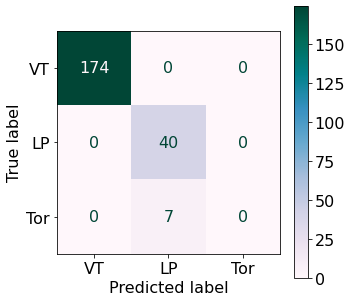

[[[ 47   0]
  [  0 174]]

 [[174   7]
  [  0  40]]

 [[214   0]
  [  7   0]]]
matriz VT  [[ 47   0]
 [  0 174]]
matriz LP  [[174   7]
 [  0  40]]
matriz Tor  [[214   0]
 [  7   0]]


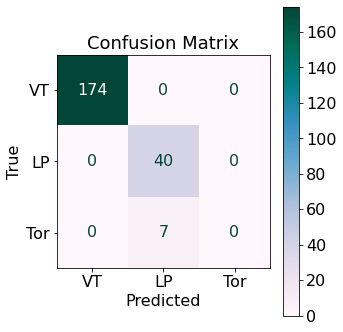

In [25]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

y_pred_ = np.rint(y_pred)
y_salida = []
for i in range(len(y_pred)):
  if y_pred_[i,0] > 0:
    y_salida.append('VT')
  if y_pred_[i,1] > 0:
    y_salida.append('LP')
  if y_pred_[i,2] > 0:
    y_salida.append('Tor') 


y_true = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_true.append('VT')
  if y_test[i,1] > 0:
    y_true.append('LP')
  if y_test[i,2] > 0:
    y_true.append('Tor')

c = confusion_matrix ( y_true , y_salida , labels = ["VT", "LP", "Tor"] , sample_weight = None)
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=["VT", "LP", "Tor"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('True', fontsize=16)
ax.set_title('Confusion Matrix', fontsize=18)
plt.tight_layout()
plt.savefig('confusion_matrix.tiff', dpi=400, format='tiff')

plt.rcParams.update({'font.size': 16})
#plt.rc('font', **font)

cm = multilabel_confusion_matrix(y_true, y_salida, labels=["VT", "LP", "Tor"])
print(cm)
cmVT = cm[0]
cmLP = cm[1]
cmTor = cm[2]
print('matriz VT ', cmVT)
print('matriz LP ', cmLP)
print('matriz Tor ', cmTor)

# **Evaluación con Métricas de Desempeño**

In [ ]:
def calcular_sensitividad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FN = CM[1,0]
  sen = 100*(TP/(TP+FN))
  print('Sensitividad ' + clase_sismo + ': {:.1f}%'.format(sen))
  return sen


def calcular_especificidad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TN = CM[0,0]
  FP = CM[0,1]
  esp = 100*(TN/(TN+FP))
  print('Especificidad ' + clase_sismo + ': {:.1f}%'.format(esp))
  return esp


def calcular_precision(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FP = CM[0,1]
  pres = 100*(TP/(TP+FP))
  print('Precisión ' + clase_sismo + ': {:.1f}%'.format(pres))
  return pres


def calcular_f1(sencitividad, precision, clase_sismo):
  f1 = 2*(precision*sencitividad)/(precision+sencitividad)
  print('f1 score ' + clase_sismo + ': {:.1f}%'.format(f1))
  return f1

In [ ]:
# Calculo de Especificidad
esp_1 = calcular_especificidad('VT')
esp_2 = calcular_especificidad('LP')
esp_3 = calcular_especificidad('Tor')
# Cálculo de Sensitividad
sen_1 = calcular_sensitividad('VT')
sen_2 = calcular_sensitividad('LP')
sen_3 = calcular_sensitividad('Tor')
# Cálculo de Precisión
pres_1 = calcular_precision('VT')
pres_2 = calcular_precision('LP')
pres_3 = calcular_precision('Tor')
# Cálculo de f1 score
f1_1 = calcular_f1(sen_1,pres_1,'VT')
f1_2 = calcular_f1(sen_2,pres_2,'LP')
f1_3 = calcular_f1(sen_3,pres_3,'Tor')

Especificidad VT: 100.0%
Especificidad LP: 95.6%
Especificidad Tor: 100.0%
Sensitividad VT: 99.4%
Sensitividad LP: 100.0%
Sensitividad Tor: 0.0%
Precisión VT: 100.0%
Precisión LP: 83.3%
Precisión Tor: nan%
f1 score VT: 99.7%
f1 score LP: 90.9%
f1 score Tor: nan%


<ipython-input-19-d14efc6aa696>:38: RuntimeWarning: invalid value encountered in long_scalars
  pres = 100*(TP/(TP+FP))


In [ ]:
from sklearn.metrics import classification_report
# y_pred_label, y_test_label
target_names = ['VT', 'LP', 'Tor']
print(classification_report(y_test, y_pred_, target_names=target_names))

              precision    recall  f1-score   support

          VT       1.00      0.99      1.00       174
          LP       0.83      1.00      0.91        40
         Tor       0.00      0.00      0.00         7

   micro avg       0.96      0.96      0.96       221
   macro avg       0.61      0.66      0.64       221
weighted avg       0.94      0.96      0.95       221
 samples avg       0.96      0.96      0.96       221



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clasificador = Model(inputs=entrada, outputs=saida)
clasificador.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
historia = clasificador.fit(X_train, y_train,
 epochs=15,
 batch_size=150,
 validation_data=(X_test, y_test),
 shuffle=True)

Epoch 1/15
13/13 [==============================] - 1s 27ms/step - loss: 0.6556 - accuracy: 0.7378 - val_loss: 0.4612 - val_accuracy: 0.8449
Epoch 2/15
13/13 [==============================] - 0s 11ms/step - loss: 0.4623 - accuracy: 0.7777 - val_loss: 0.3674 - val_accuracy: 0.8449
Epoch 3/15
13/13 [==============================] - 0s 9ms/step - loss: 0.3767 - accuracy: 0.7777 - val_loss: 0.2922 - val_accuracy: 0.8449
Epoch 4/15
13/13 [==============================] - 0s 10ms/step - loss: 0.3102 - accuracy: 0.7777 - val_loss: 0.2361 - val_accuracy: 0.8449
Epoch 5/15
13/13 [==============================] - 0s 10ms/step - loss: 0.2617 - accuracy: 0.7777 - val_loss: 0.1960 - val_accuracy: 0.8449
Epoch 6/15
13/13 [==============================] - 0s 12ms/step - loss: 0.2275 - accuracy: 0.7777 - val_loss: 0.1682 - val_accuracy: 0.8449
Epoch 7/15
13/13 [==============================] - 0s 11ms/step - loss: 0.2037 - accuracy: 0.7777 - val_loss: 0.1488 - val_accuracy: 0.8449
Epoch 8/15
13/

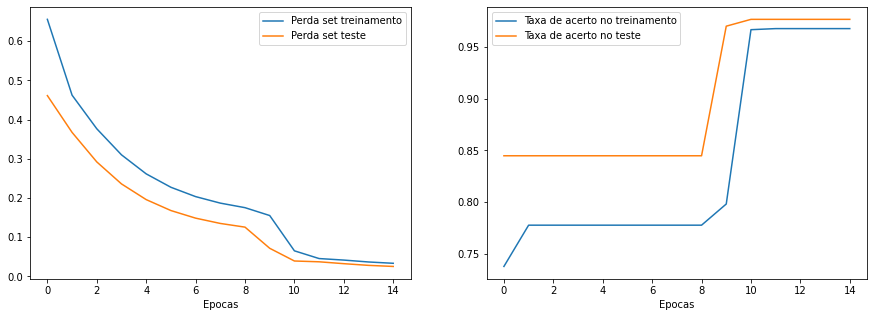

In [ ]:
import matplotlib.pyplot as plt
plt.figure(5, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], label="Perda set treinamento")
plt.plot(historia.history["val_loss"], label="Perda set teste")
plt.xlabel('Epocas')
plt.legend()
plt.subplot(1,2,2)
plt.plot(historia.history["accuracy"], label="Taxa de acerto no treinamento")
plt.plot(historia.history["val_accuracy"], label="Taxa de acerto no teste")
plt.xlabel('Epocas')
plt.legend()

10/10 [==============================] - 0s 3ms/step


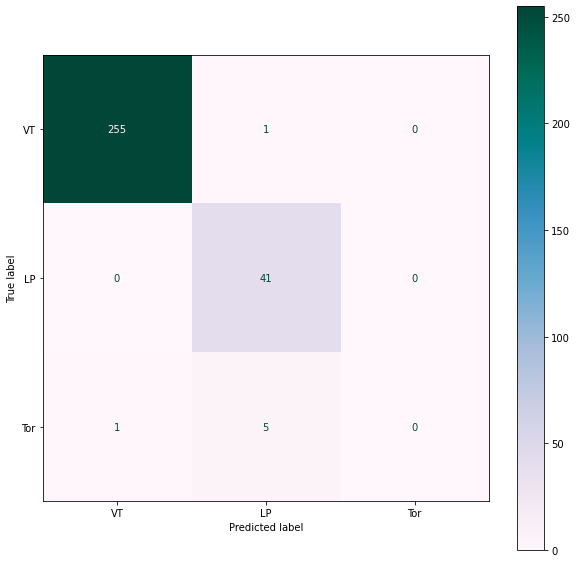

[[[ 46   1]
  [  1 255]]

 [[256   6]
  [  0  41]]

 [[297   0]
  [  6   0]]]
matriz VT  [[ 46   1]
 [  1 255]]
matriz LP  [[256   6]
 [  0  41]]
matriz Tor  [[297   0]
 [  6   0]]


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

clasificador = Model(inputs=entrada, outputs=saida)
y_pred = clasificador.predict(X_test)
y_pred_ = np.rint(y_pred)

y_true = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_true.append('VT')
  if y_test[i,1] > 0:
    y_true.append('LP')
  if y_test[i,2] > 0:
    y_true.append('Tor')

y_salida = []
for i in range(len(y_pred_)):
  if y_pred_[i,0] > 0:
    y_salida.append('VT')
  if y_pred_[i,1] > 0:
    y_salida.append('LP')
  if y_pred_[i,2] > 0:
    y_salida.append('Tor') 

# Matriz de confusión multiclase
c = confusion_matrix ( y_true , y_salida , labels = ["VT", "LP", "Tor"] , sample_weight = None)
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=["VT", "LP", "Tor"])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
plt.show()
plt.show()
cm = multilabel_confusion_matrix(y_true, y_salida, labels=["VT", "LP", "Tor"])
print(cm)
cmVT = cm[0]
cmLP = cm[1]
cmTor = cm[2]
print('matriz VT ', cmVT)
print('matriz LP ', cmLP)
print('matriz Tor ', cmTor)

**Sensitividad y Especificidad**


*   Verdaderos Positivos (TP): La clase de sismo de interés que ha sido clasificada
correctamente,

*   Falsos negativos (FN): La clase de sismo de interés que fue clasificada como otro
tipo de sismo


*   Verdadero negativo (TN): Otros tipo de sismo que fue correctamente clasificado
como un tipo de sismo diferente a la clase de interés, y

*   Falsos positivos (FP): cuando un sismo diferente fue clasificado como si fuera el
simo de la clase de interés.

La **sensitividad** mide la proporción de los sismos de interés detectados
correctamente, una sensitividad del 100% detectará todos los sismos de interés:

$$Sensitividad = \frac{TP}{TP+FN}$$

La **especificidad** mide la proporción de otro tipo de sismos que fueron detectados
correctamente diferentes a la clase de interés. Una especificidad del 100% detectará
sismos diferentes a la clase de interés:

$$Especificidad = \frac{TN}{TN+FP}$$

In [ ]:
def calcular_sensitividad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FN = CM[1,0]
  sen = 100*(TP/(TP+FN))
  print('Sensitividad ' + clase_sismo + ': {:.1f}%'.format(sen))
  return sen


def calcular_especificidad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TN = CM[0,0]
  FP = CM[0,1]
  esp = 100*(TN/(TN+FP))
  print('Especificidad ' + clase_sismo + ': {:.1f}%'.format(esp))
  return esp


def calcular_precision(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FP = CM[0,1]
  pres = 100*(TP/(TP+FP))
  print('Precisión ' + clase_sismo + ': {:.1f}%'.format(pres))
  return pres


def calcular_f1(sencitividad, precision, clase_sismo):
  f1 = 2*(precision*sencitividad)/(precision+sencitividad)
  print('f1 score ' + clase_sismo + ': {:.1f}%'.format(f1))
  return f1

In [ ]:
# Calculo de Especificidad
esp_1 = calcular_especificidad('VT')
esp_2 = calcular_especificidad('LP')
esp_3 = calcular_especificidad('Tor')
# Cálculo de Sensitividad
sen_1 = calcular_sensitividad('VT')
sen_2 = calcular_sensitividad('LP')
sen_3 = calcular_sensitividad('Tor')
# Cálculo de Precisión
pres_1 = calcular_precision('VT')
pres_2 = calcular_precision('LP')
pres_3 = calcular_precision('Tor')
# Cálculo de f1 score
f1_1 = calcular_f1(sen_1,pres_1,'VT')
f1_2 = calcular_f1(sen_2,pres_2,'LP')
f1_3 = calcular_f1(sen_3,pres_3,'Tor')

Especificidad VT: 97.9%
Especificidad LP: 97.7%
Especificidad Tor: 100.0%
Sensitividad VT: 99.6%
Sensitividad LP: 100.0%
Sensitividad Tor: 0.0%
Precisión VT: 99.6%
Precisión LP: 87.2%
Precisión Tor: nan%
f1 score VT: 99.6%
f1 score LP: 93.2%
f1 score Tor: nan%


<ipython-input-48-d14efc6aa696>:38: RuntimeWarning: invalid value encountered in long_scalars
  pres = 100*(TP/(TP+FP))


In [ ]:
from sklearn.metrics import classification_report
# y_pred_label, y_test_label
target_names = ['VT', 'LP', 'Tor']
print(classification_report(y_test, y_pred_, target_names=target_names))

              precision    recall  f1-score   support

          VT       1.00      1.00      1.00       256
          LP       0.87      1.00      0.93        41
         Tor       0.00      0.00      0.00         6

   micro avg       0.98      0.98      0.98       303
   macro avg       0.62      0.67      0.64       303
weighted avg       0.96      0.98      0.97       303
 samples avg       0.98      0.98      0.98       303



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3


for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 3

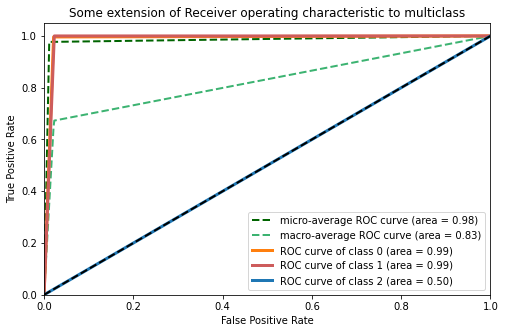

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,5))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="darkgreen", #deeppink
    linestyle="--",
    linewidth=2,
    )

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="mediumseagreen", #
    linestyle="--",
    linewidth=2,
    )

colors = cycle(["tab:orange", "indianred", "tab:blue"])
for i, color in zip(range(n_classes), colors):
  plt.plot(
      fpr[i],
      tpr[i],
      color=color,
      lw=lw,
      label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
   )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()                                                                 